# Re-gridding xecmip

The aim of this notebook is to re-grid all of the zecmip data to a common grid.


In [1]:
import xarray as xr
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import warnings
import xesmf 
import cftime
warnings.filterwarnings('ignore')
from typing import NamedTuple, List
from functools import partial
from multiprocessing import Pool

In [9]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD', 'modules'))

In [10]:
sys.path.append('modules')
import constants
import xarray_class_accessors as xca
import sn_plotting
import climtas
from typing import Callable
import open_ds
import json

In [11]:
# File that contains all the saved paths for zecmip runs
with open('data/zecmip_model_paths.json', 'r') as f:
    zecmip_model_paths = json.loads(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'data/zecmip_model_paths.json'

In [ ]:
pprint(zecmip_model_paths)

In [ ]:
zecmip_model_paths.keys()

In [ ]:
zecmip_model_paths['1000pgc'].keys()

In [ ]:
needed_experiments = list(zecmip_model_paths['1000pgc']['needed'].values())
needed_experiments

# Functions

In [22]:
def open_and_rename(fname, open_func):
    '''Open the file, then add the model dimension'''
    ds = open_func(fname)
    
    model = fname.split('/')[8]
    print(model)
    ds = ds.expand_dims('model').assign_coords(model=('model', [model]))

    return ds

In [23]:
class ModelGrid(NamedTuple):
    model: str
    lat: float
    lon: float
    no_points: float = None

In [24]:
def regrid_dataset_climtas(to_regrid_ds: xr.Dataset, target_ds: xr.Dataset)->xr.Dataset:
    '''Regrid data using xesmf'''
    print('Regridding data using climtas')
    regridder = climtas.regrid.Regridder(to_regrid_ds, target_ds)
    
    regridded_ds = regridder(to_regrid_ds)
    
    return regridded_ds

In [25]:
def regrid_dataset_xesmf(to_regrid_ds: xr.Dataset, target_ds: xr.Dataset)->xr.Dataset:
    '''Regrid data using xesmf'''
    print('Regridding data using xesmf')
    regridder = xesmf.Regridder(to_regrid_ds, target_ds, method='bilinear', periodic=True)
    
    regridded_ds = regridder(to_regrid_ds)
    
    return regridded_ds

In [26]:
def regrid_retimestep_add_dim(ds: xr.Dataset, base_ds: xr.Dataset, 
                              regrid_func: Callable = regrid_dataset_xesmf)->xr.Dataset:
    '''
    Function that is a collection of functions.
    Function will
        * refactor dimensions (latitude -> lat ect.)
        * regrid the dataset to match base_ds
        * Add model dim
        * Change time to start from 0.
    '''

    print(f'\n{ds.model.values}')
    # Make sure dims have correct names
    ds = open_ds.refactor_dims(ds)
    
    print('Removing uneeded coordinates')
    
    ds = ds.drop(['bnds', 'height', 'bounds', 'lev', 'level'], errors='ignore')[['tas']]

    # Regrid the dataset
    ds = regrid_func(ds, base_ds)

    # Time should all be the same
    ds = ds.resample(time='Y').mean()
    print('Resample to yearly frequency')
    ds['time'] = open_ds.make_new_time(ds, freq='1Y')
    
    return ds

The following code uses partial functions to reduce code being re-used

# Experiment

In [13]:
needed_experiments_wild_card = [os.path.join(fname, '*.nc') for fname in needed_experiments]
needed_experiments_wild_card[:2]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc']

In [29]:
# Opening all the needed experiments with the open_and_raname function. This function
# takes an function as an arguement on how to open the dataset. For this a xr.open_mfdataset
# with use_cftime=True filled.
experiment_ds_raw_list = [open_and_rename(fname,  partial(xr.open_mfdataset, use_cftime=True))
                          for fname in needed_experiments_wild_card]

CanESM5
MIROC-ES2L
UKESM1-0-LL
MPI-ESM1-2-LR
GISS-E2-1-G-CC
CESM2
NorESM2-LM
GFDL-ESM4


In [30]:
len(experiment_ds_raw_list)

8

# Pi-control

In [31]:
needed_experiments[:3]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210']

In [32]:
# Partial filled open_ds.zecmip_open_matching_picontrol function.
open_func = partial(open_ds.zecmip_open_matching_picontrol, unique_picontrol_paths = zecmip_model_paths['picontrol'])

# Same as above but using the open_ds function
picontrol_ds_raw_list = [open_and_rename(fname,  open_func) for fname in needed_experiments]

Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429
CanESM5
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622
MIROC-ES2L
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210
UKESM1-0-LL
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815
MPI-ESM1-2-LR
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202
GISS-E2-1-G-CC
Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119
CESM2
Attempting to open matching picontrol for:
/g/data

# Grid Analsis

Looking at the grids for all models

In [34]:
model_grids = []
for ds in picontrol_ds_raw_list:
    model = str(ds.model.values)
    lat_grid = np.mean(np.unique(np.round(np.diff(ds.lat.values),3)))
    lon_grid = np.mean(np.unique(np.round(np.diff(ds.lon.values),3)))
    
    model_grids.append(ModelGrid(model, lat=lat_grid, lon=lon_grid))

In [35]:
model_grids

[ModelGrid(model="['CanESM5']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['MIROC-ES2L']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['UKESM1-0-LL']", lat=1.25, lon=1.875, no_points=None),
 ModelGrid(model="['MPI-ESM1-2-LR']", lat=1.8605999999999998, lon=1.875, no_points=None),
 ModelGrid(model="['GISS-E2-1-G-CC']", lat=2.0, lon=2.5, no_points=None),
 ModelGrid(model="['CESM2']", lat=0.942, lon=1.25, no_points=None),
 ModelGrid(model="['NorESM2-LM']", lat=1.895, lon=2.5, no_points=None),
 ModelGrid(model="['GFDL-ESM4']", lat=1.0, lon=1.25, no_points=None)]

# Regridding

## Opening Base FIles

In [36]:
needed_experiments[:4]

['/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210',
 '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815']

In [37]:
# base_fpath = '/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202'
# base_fpath = '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210'
base_fpath = '/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815'

In [38]:
base_experiment_ds = xr.open_mfdataset(os.path.join(base_fpath, '*.nc'))[['tas']]
base_experiment_ds = open_ds.refactor_dims(base_experiment_ds)
base_experiment_ds

<xarray.Dataset>
Dimensions:  (time: 2220, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1915-01-16T12:00:00 ... 2099-12-16T12:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(240, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP CDRMIP
    branch_method:          standard
    branch_time_in_child:   23740.0
    branch_time_in_parent:  36524.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/8c15b0f1-ed3a-405d-aa90-dc21eac487fc

In [39]:
base_picontrol_ds = open_ds.zecmip_open_matching_picontrol(
            base_fpath, zecmip_model_paths['picontrol'])[['tas']]
base_picontrol_ds

Attempting to open matching picontrol for:
/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815


<xarray.Dataset>
Dimensions:  (time: 12000, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2849-12-16 12:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(240, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  18262.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/6e55f8ff-5806-428e-a182-32e70be98e87

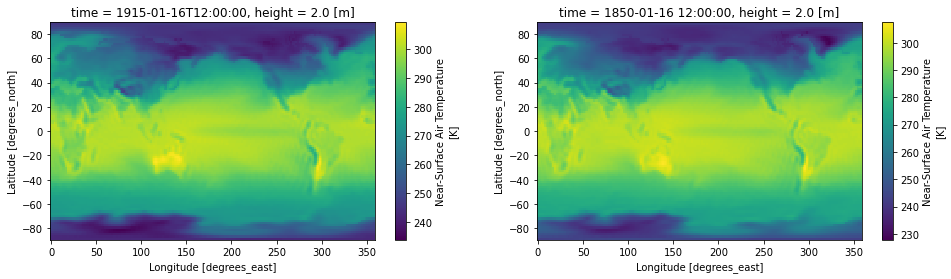

In [40]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
base_experiment_ds.tas.isel(time=0).plot(ax=ax1)
ax2 = fig.add_subplot(122)
base_picontrol_ds.tas.isel(time=0).plot(ax=ax2)

In [41]:
# Making sure the pi-control and experiment have the same grid.
np.testing.assert_equal(base_picontrol_ds.lat.values, base_experiment_ds.lat.values)
np.testing.assert_equal(base_picontrol_ds.lon.values, base_experiment_ds.lon.values)

## Regridding all files.

In [42]:
# Creating a partical function
experiment_regrid_function = partial(regrid_retimestep_add_dim, base_ds=base_experiment_ds, 
                                    regrid_func = regrid_dataset_xesmf)
# Creating a partical function
picontrol_regrid_func = partial(regrid_retimestep_add_dim, base_ds=base_picontrol_ds,
                               regrid_func = regrid_dataset_xesmf)

In [43]:
%%time
with Pool() as pool:
    experiment_ds_list = pool.map(experiment_regrid_function, experiment_ds_raw_list)


['CanESM5']
Removing uneeded coordinates
Regridding data using xesmf

['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf

['UKESM1-0-LL']
Removing uneeded coordinates

Regridding data using xesmf
['MPI-ESM1-2-LR']
['GISS-E2-1-G-CC']

Removing uneeded coordinatesRemoving uneeded coordinates

Regridding data using xesmf
Regridding data using xesmf

['CESM2']
Removing uneeded coordinates
['NorESM2-LM']

Removing uneeded coordinates
Regridding data using xesmfRegridding data using xesmf


['GFDL-ESM4']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 185
Resample to yearly frequency
Chaning time to range bet

In [44]:
# Applying partical function to every ds in list.
with Pool() as pool:
    picontrol_ds_list = pool.map(picontrol_regrid_func, picontrol_ds_raw_list)


['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf
['CanESM5']

Removing uneeded coordinates
Regridding data using xesmf

['UKESM1-0-LL']
Removing uneeded coordinates
Regridding data using xesmf

['GISS-E2-1-G-CC']

['MPI-ESM1-2-LR']Removing uneeded coordinates

Removing uneeded coordinates
Regridding data using xesmfRegridding data using xesmf


['CESM2']
Removing uneeded coordinates
Regridding data using xesmf

['NorESM2-LM']
Removing uneeded coordinates
Regridding data using xesmf

['GFDL-ESM4']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 165
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 501
Resample to yearly frequency
Chaning time to range bet

## Verification of Re-grid

Testing to make sure all the values match!

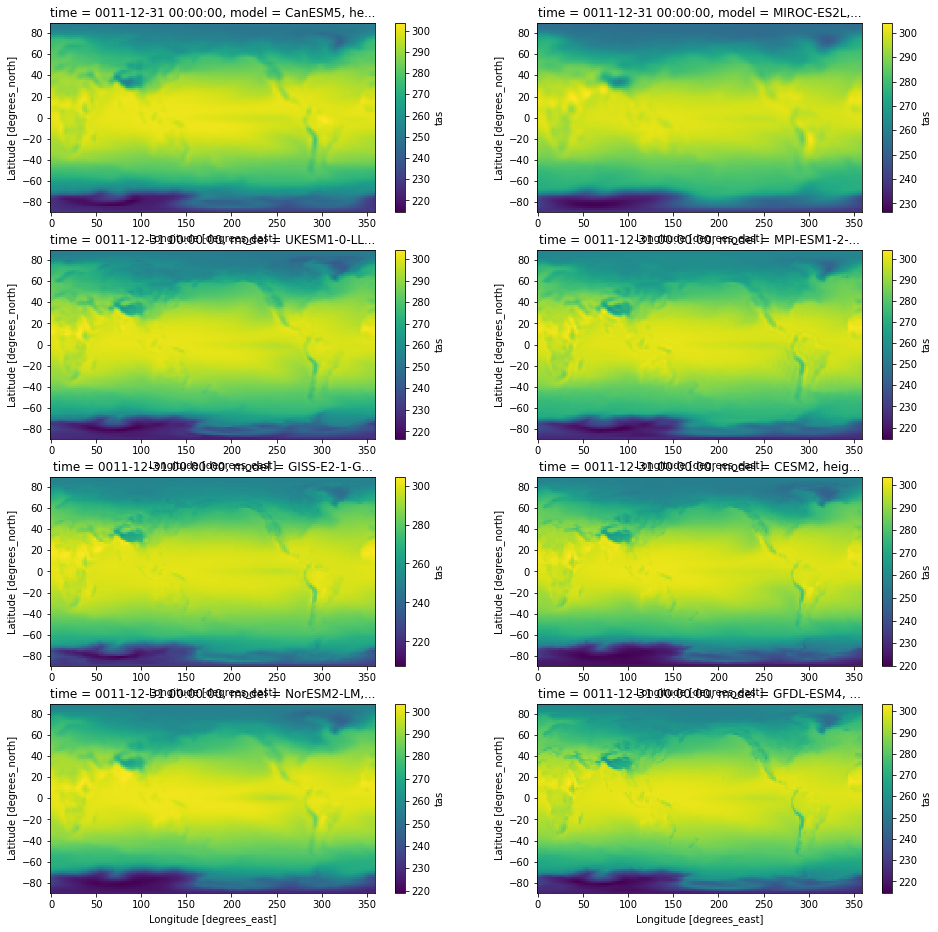

In [45]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.isel(time=10).plot(ax=ax)
#     fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_INIT, 'zec_02_bugged_regrid.png'))

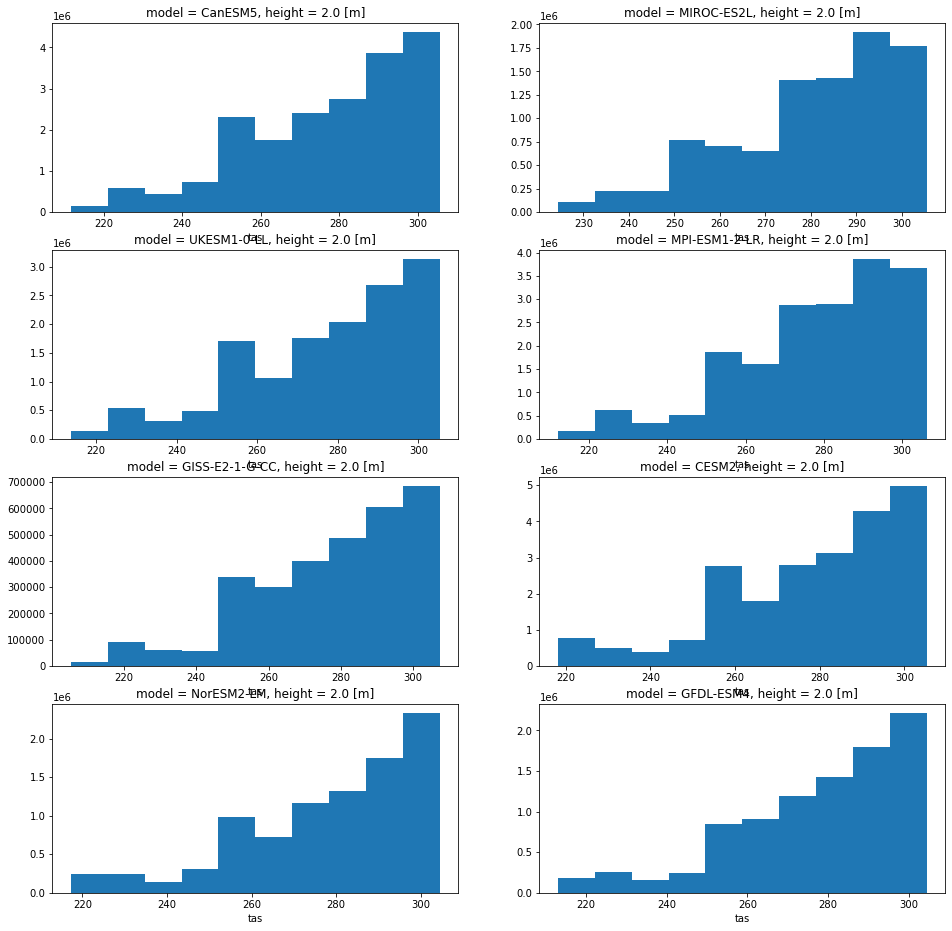

In [46]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.plot(ax=ax)

In [47]:
for ds in picontrol_ds_list:
    np.testing.assert_equal(ds.lat.values, base_picontrol_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_picontrol_ds.lon.values)

In [48]:
for ds in experiment_ds_list:
    np.testing.assert_equal(ds.lat.values, base_experiment_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_experiment_ds.lon.values)

In [49]:
picontrol_ds_list[:2]

[<xarray.Dataset>
 Dimensions:  (time: 1051, model: 1, lat: 96, lon: 192)
 Coordinates:
   * time     (time) object 0001-12-31 00:00:00 ... 1051-12-31 00:00:00
   * model    (model) <U7 'CanESM5'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
 Data variables:
     tas      (time, model, lat, lon) float32 dask.array<chunksize=(1, 1, 96, 192), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:  (time: 500, model: 1, lat: 96, lon: 192)
 Coordinates:
   * time     (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
   * model    (model) <U10 'MIROC-ES2L'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
 Data variables:
     tas      (time, model, lat, lon) float32 dask.array<chunksize=(1, 1, 96, 192), meta=np

In [50]:
# The frequency is about one month for all the models
for ds in picontrol_ds_raw_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 30 days, 0:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00


In [51]:
# The time should now be yearly.
for ds in picontrol_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00


In [52]:
# The frequency is about one month for all the models
for ds in experiment_ds_raw_list:
    time_diff = np.diff(experiment_ds_raw_list[0].time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 29 days, 12:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00


In [53]:
# The time should now be yearly.
for ds in experiment_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00


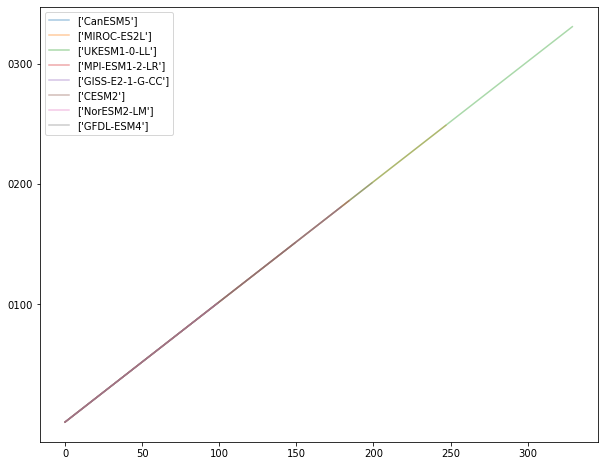

In [54]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for ds in experiment_ds_list:
    ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)
ax.legend(loc='best')

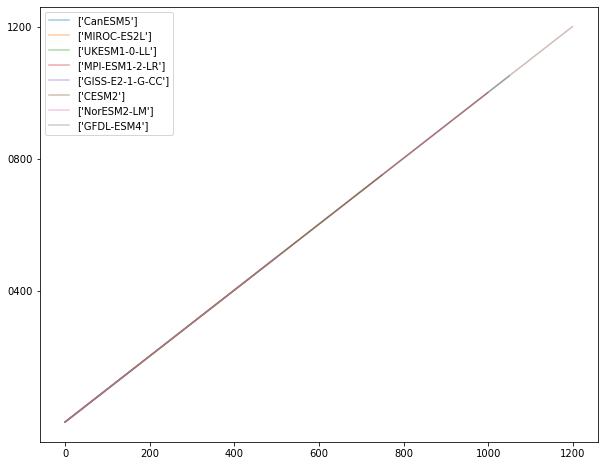

In [55]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

for ds in picontrol_ds_list:
    ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)    
ax.legend(loc='best')

# Saving

In [57]:
dir(constants)

['DECK_DIR',
 'IMAGE_SAVE_DIR_INIT',
 'IMAGE_SAVE_DIR_TOP_LEVEL',
 'LONGRUMIP_MODELS_MIN_1850',
 'LONGRUNMIP_CONSECMET_DIR',
 'LONGRUNMIP_DIR',
 'LONGRUNMIP_MODELS',
 'LONGRUNMIP_RETIMED_DIR',
 'LONRUNMIP_LOESS_DIR',
 'MODELS_TO_DROP',
 'MODULE_DIR',
 'PHD_ROOT_DIR',
 'ZECMIP_DIR',
 'ZECMIP_LOCAL_DIR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'os']

In [59]:
os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol')

'/g/data/w40/ab2313/PhD/zecmip/regridded'

In [60]:
for ds in picontrol_ds_list:
    model = str(ds.model.values[0])
    print(model)
    ds.to_netcdf(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', model + '.nc'))

CanESM5
MIROC-ES2L
UKESM1-0-LL
MPI-ESM1-2-LR
GISS-E2-1-G-CC
CESM2
NorESM2-LM
GFDL-ESM4


In [61]:
for ds in experiment_ds_list:
    model = str(ds.model.values[0])
    print(model)
    save_name = os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', '4xCO2', model + '.nc')
    print(save_name)
    ds.to_netcdf(save_name)

CanESM5
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/CanESM5.nc
MIROC-ES2L
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/MIROC-ES2L.nc
UKESM1-0-LL
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/UKESM1-0-LL.nc
MPI-ESM1-2-LR
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/MPI-ESM1-2-LR.nc
GISS-E2-1-G-CC
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/GISS-E2-1-G-CC.nc
CESM2
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/CESM2.nc
NorESM2-LM
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/NorESM2-LM.nc
GFDL-ESM4
/g/data/w40/ab2313/PhD/zecmip/regridded/4xCO2/GFDL-ESM4.nc
